PARSEVALS THEOREM CODE THEORY and METHOD

When converting from the time domain to the frequency domain it is vital that energy has to be conserved. 
Parseval's Theorem states that the mean-square power in the time domain and the total power in the frequency domain
should be equal, but the lightkurve module does not conserve Parseval's theorem. 

Therefore, to enforce Parseval's Theorem, we will adjust the power values in the frequency domain by a set factor. First we will need to calculate both the mean-square power in (t) and the total power in (f).
This is done to check if they are equal. 

Mean-square power time domain:
\begin{equation}
msp_t =\frac{1}{N}\sum_i^N y_i^2 \hspace{2cm} (eqn 1)
\end{equation}

Total power in the frequency domain:
\begin{equation}
tp_f =\frac{2\sigma^2 T}{N} \hspace{2cm} (eqn 2)
\end{equation}

$$\sigma^2=\frac{1}{N}\sum_i^N y_i^N \hspace{2cm} (eqn 3)$$

In eqn 1, $y$ is normalised flux in the time domain, whilst in eqn 2, $<y>$ is total power in the frequency domain.
We need to calculate an adjustment factor, 'A' by which the power values in the frequency domain will be scaled by. 

P_t = Mean-square power time domain, and should be equal to the power in the frequency domain. 
We will set $P_t$ equal to equation 2

Therefore:
\begin{equation}
P_t = \frac{2\sigma^2 T}{N} \hspace{1cm} where \hspace{1cm} \sigma^2 = \frac{1}{N}\sum_i^N(Ay_i)^2
\end{equation}

\begin{equation}
\frac{NP_t}{2T} = \sigma^2 = \frac{1}{N}\sum_i^N (Ay_i)^2 = \frac{A^2}{N}\sum_i^N (y_i)^2 \hspace{1cm
} \Rightarrow \hspace{1cm} A=\sqrt{\frac{P_t N^2}{2T\sum_i^Ny_i^2}} = \sqrt{\frac{P_t N}{2T\sigma^2}}
\end{equation}

In [10]:
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [11]:
# DEFINING THE FUNCTIONS NECESSARY FOR THE IMPLEMENTATION OF PARSEVALS THEOREM

'''Calculates the sigma squared of an array'''
def sigma2(a): 
    N = len(a)
    a = np.square(a)
    a = np.nansum(a) #nansum sums the array but skips values which are nan
    return a/N

'''Calculates the power in the frequency domain'''
def power(a,T):
    N = len(a)
    return 2*sigma2(a)*T/N

In [12]:
# WORK ON AUTOMATING TARGET READ-IN

targetname = ['KIC3427720', 'KIC3656476', 'KIC3735871', 'KIC4914923', 'KIC5184732']

for i in targetname:
    print(i)

KIC3427720
KIC3656476
KIC3735871
KIC4914923
KIC5184732


The mean-square power in the time domain is 0.9999979862871891
The total length of observation of the target is 1459.5086715072684 days or 126101549.218228 seconds.
The cadence of the observations is 58.84963490534574 seconds.
[  21610   21611   21612 ... 2164413 2164418 2164419]


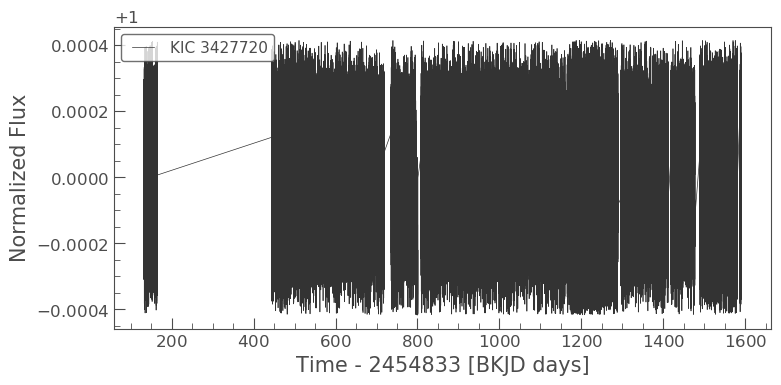

In [13]:
#for i in targetname:
#    target = targetname[i]
    
target = targetname[0]

search = lk.search_lightcurvefile(str(target), cadence = 'short', mission = 'kepler') 
#print(search) # displays the result of the search

# DOWNLOAD ALL DATA - since will treat as one long lightcurve
LC = search.download_all()
LC = LC.PDCSAP_FLUX #pre-reduced data BUT is not always good... SAP = Simple Aperture Photometry
LC = LC.stitch() #stitches all the lightcurves together to create one long lightcurve

LC_Trimmed = LC.remove_nans().flatten(201).remove_outliers(4)
#.remove_nans() --> removes not a number values  
#.flatten() -->  number in bracket is the number of timestamps it will attempt to flatten to, must be odd
#.remove_outliers --> removes outliers up to X sigma - ie will remove the large dropouts

LC_data = LC_Trimmed.to_pandas() #should output the data as a pandas dataframe, which can be viewed as a table
LC_data

LC_Trimmed.plot()

msp_t = sigma2(LC_Trimmed.flux) #calculates the mean-square power in the time domain 
#Lightcurves.flux extracts the data of the flux values from Lightcurves
print(f'The mean-square power in the time domain is {msp_t}')

total_time = LC_Trimmed.time[-1]-LC_Trimmed.time[0] 
total_time_sec = total_time*24*60*60
print(f'The total length of observation of the target is {total_time} days or {total_time_sec} seconds.')
#print(f'The total length of observation of the target is .')
#.time extracts the time data from  Lightcurves total_time is the time over which the observations were made
cadence_days = LC_Trimmed.time[2]-LC_Trimmed.time[1]
cadence = cadence_days*24*60*60
print(f'The cadence of the observations is {cadence} seconds.')

print(LC_Trimmed.cadenceno) #these number the bins in the time-domain (?)

The highest frequency is 8496.334951015247 uHz
The minimum power is 3.502798342379194e-18 1 / uHz
The maximum power is 2.9216506839444987e-10 1 / uHz
The average power is 1.7352298529890844e-12 1 / uHz


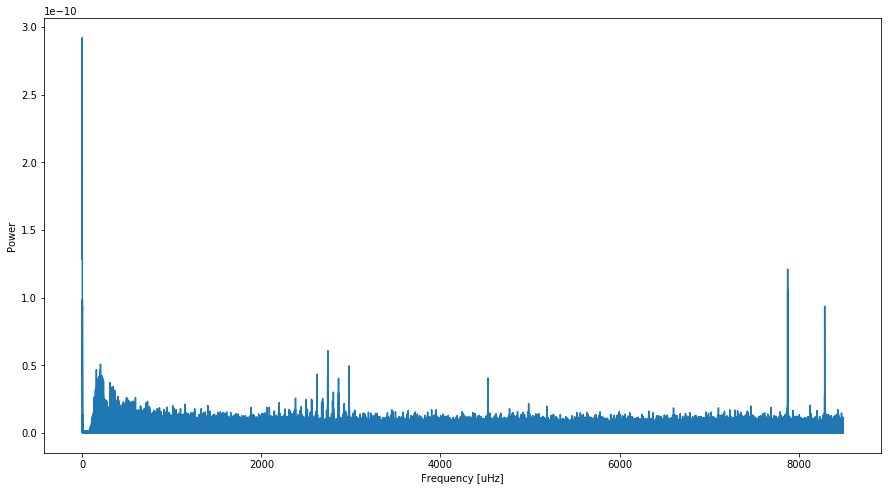

The total power in the frequency domain is 2.738733363377048e-21


In [16]:
# MAKING THE POWER SPECTRUM (aka a periodogram)
savename = str(target) + '_F-P_Spec.png'

pg = LC_Trimmed.to_periodogram(normalization = 'psd')
f,p = pg.frequency.value, pg.power.value

#print(f'The number of bins in the frequency domain is {total_time / cadence_days}')

print(f'The highest frequency is {pg.frequency[-1]}')
print(f'The minimum power is {np.min(pg.power)}')
print(f'The maximum power is {np.max(pg.power)}')

print(f'The average power is {np.mean(pg.power)}')
#print(f'The average power in ppm^2 is {(np.average(pg.power))**2}')
# PLOTTING SERIES
figure(figsize = (15,8))
plot(f, p)
xlim()
xlabel('Frequency [uHz]')
ylim()
ylabel('Power')
plt.show()
#plt.savefig(str(savename), overwrite = True) ---> NOT WORKING ATM - produces blank white image

tp_f = power(p,total_time_sec) # calculates the power in the frequency domain
print(f'The total power in the frequency domain is {tp_f}')

The adjusted frequency domain power is 0.9999979862871886
The percentage difference is 4.440901041199947e-14 %


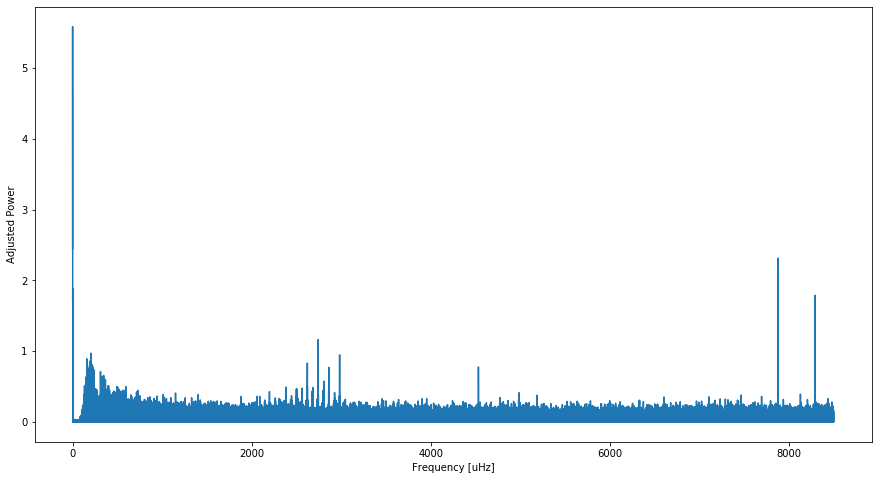

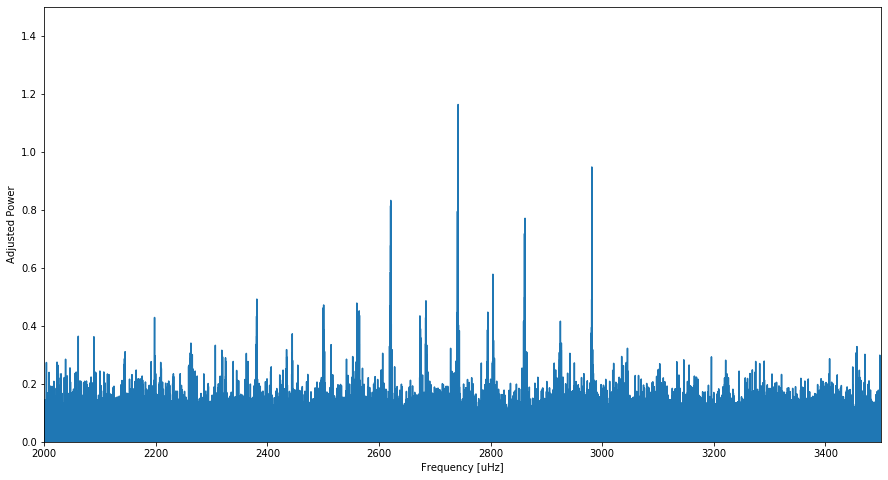

In [17]:
#The adjustment factor, AF will be multipled by the power values in the frequency domain. 
#It will ensure energy conservation between the frequency and time domains.
AF = np.sqrt((msp_t*len(f))/(2*total_time_sec*sigma2(p)))

Ap = AF*p #changing the power values in the frequency domain by the adjustment factor
AdjustedP = power(Ap, total_time_sec)
print(f'The adjusted frequency domain power is {AdjustedP}')
np.abs(msp_t - AdjustedP)

difference = np.abs(msp_t - AdjustedP) / AdjustedP
Perc_diff = difference * 100
print(f'The percentage difference is {Perc_diff} %')

figure(figsize = (15, 8))
plot(f,Ap)
xlabel('Frequency [uHz]')
ylabel('Adjusted Power')
plt.show()

figure(figsize = (15, 8))
plot(f,Ap)
xlabel('Frequency [uHz]')
ylabel('Adjusted Power')
xlim(2000, 3500)
ylim(0, 1.5)
plt.show()